# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [15]:
# import libraries
from pyspark.sql import SparkSession,SQLContext
from pyspark.sql.functions import udf
import datetime
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import datetime
import numpy as np
import pandas as pd
import seaborn as sns

In [16]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify session 1") \
    .getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.app.name', 'Sparkify session 1'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '0ac39fa5bd98'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '40473'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1568749187768'),
 ('spark.ui.showConsoleProgress', 'true')]

In [17]:
spark.sparkContext.version

'2.4.3'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [18]:
df = spark.read.json('mini_sparkify_event_data.json')
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [19]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [20]:
print(df.count())
df_clean = df.dropna(how = "any", subset = ["userId", "sessionId"])
print(df_clean.count())

286500
286500


In [21]:
print(df_clean.count())
df_clean = df_clean.filter(df_clean["userId"] != "")
print(df_clean.count())

286500
278154


<h3> comments </h3>
no Null values but some user nulls as they were not registered

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [22]:
df_clean.createOrReplaceTempView("log_table")

In [23]:
spark.sql("SELECT DISTINCT(page) \
            FROM log_table\
            ").show(truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Settings                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



In [24]:
spark.sql("SELECT count(distinct(userId)), page\
            FROM log_table\
            where page in ('Cancellation Confirmation','Submit Downgrade','Downgrade') \
            group by 2"
        ).show(truncate=False)

+----------------------+-------------------------+
|count(DISTINCT userId)|page                     |
+----------------------+-------------------------+
|49                    |Submit Downgrade         |
|154                   |Downgrade                |
|52                    |Cancellation Confirmation|
+----------------------+-------------------------+



In [25]:
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%d-%b-%Y %H:%M:%S"))
df_clean = df_clean.withColumn("time", get_time("ts"))
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='01-Oct-2018 00:01:57')

In [26]:
df_clean = df_clean.withColumn("registration_time", get_time("registration"))
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='01-Oct-2018 00:01:57', registration_time='28-Sep-2018 22:22:42')

In [27]:
get_usage = udf(lambda x,y: x-y)
df_clean = df_clean.withColumn("usage", get_usage('ts','registration'))
df_clean.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='01-Oct-2018 00:01:57', registration_time='28-Sep-2018 22:22:42', usage='178755000')

In [28]:
flag_churn = udf(lambda x: 1 if x in ('Cancellation Confirmation') else 0, IntegerType())
df_clean = df_clean.withColumn("churn", flag_churn("page"))
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_clean = df_clean.withColumn("churn",Fsum("churn").over(windowval))
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='08-Oct-2018 12:58:54', registration_time='27-Sep-2018 02:45:40', usage='987194000', churn=0)

In [57]:
flag_adv = udf(lambda x: 1 if x in ('Roll Advert') else 0, IntegerType())
df_clean = df_clean.withColumn("advert", flag_adv("page"))
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df_clean = df_clean.withColumn("advert",Fsum("advert").over(windowval))
df_clean.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='08-Oct-2018 12:58:54', registration_time='27-Sep-2018 02:45:40', usage='987194000', churn=0, advert=52)

In [30]:
df_clean.createOrReplaceTempView("log_table")

In [31]:
spark.sql("SELECT userId, page, churn, time\
            FROM log_table\
            where page in ('Cancellation Confirmation') \
            order by 1"
        ).show(truncate=False)

+------+-------------------------+-----+--------------------+
|userId|page                     |churn|time                |
+------+-------------------------+-----+--------------------+
|100001|Cancellation Confirmation|2    |02-Oct-2018 16:36:45|
|100003|Cancellation Confirmation|2    |11-Oct-2018 16:19:41|
|100005|Cancellation Confirmation|2    |19-Oct-2018 17:57:05|
|100006|Cancellation Confirmation|2    |05-Oct-2018 15:24:30|
|100007|Cancellation Confirmation|2    |29-Nov-2018 11:45:09|
|100009|Cancellation Confirmation|2    |27-Oct-2018 03:31:44|
|100011|Cancellation Confirmation|2    |01-Oct-2018 18:04:45|
|100012|Cancellation Confirmation|2    |01-Nov-2018 19:35:00|
|100013|Cancellation Confirmation|2    |02-Nov-2018 18:53:36|
|100014|Cancellation Confirmation|2    |20-Nov-2018 19:04:09|
|100015|Cancellation Confirmation|2    |24-Nov-2018 15:35:53|
|100017|Cancellation Confirmation|2    |20-Oct-2018 19:14:07|
|100019|Cancellation Confirmation|2    |07-Oct-2018 22:57:51|
|100021|

<h3> comments </h3>
it seems 49 users requested to downgrade, 154 have already downgraded and 52 request to cancel  <br>
created churn collumn to identify possible target people

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [32]:
df_feat_users=spark.sql("SELECT distinct(userId) FROM log_table"
        )
df_feat_users= df_feat_users.toPandas()
df_feat_users.describe()

,userId
count,225
unique,225
top,300012
freq,1


In [33]:
df_feat_churn=spark.sql("SELECT distinct(userId), \
                        if (churn > 0, 1, 0) as churn\
                        FROM log_table group by 1,2"
        )
df_feat_churn= df_feat_churn.toPandas()
df_feat_churn.head(10)

,userId,churn
0,100010,0
1,200002,0
2,125,1
3,124,0
4,51,1
5,7,0
6,15,0
7,54,1
8,155,0
9,100014,1


In [34]:
df_feat_advert=spark.sql("SELECT distinct(userId), \
                        if (advert > 0, 1, 0) as advert\
                        FROM log_table group by 1,2"
        )
df_feat_advert= df_feat_advert.toPandas()
df_feat_advert.head(10)

,userId,advert
0,100010,1
1,200002,1
2,125,1
3,124,1
4,51,0
5,7,1
6,15,1
7,54,1
8,155,1
9,100014,1


In [35]:
df_feat_paid=spark.sql("SELECT distinct(userId) userId,\
            if (level='paid',1,0) as level\
            FROM log_table\
            "
        )
df_feat_paid= df_feat_paid.toPandas()
df_feat_paid.groupby('level').count()

,userId
level,
0,195
1,165


In [36]:
df_feat_tu=spark.sql("SELECT userId, count(*) as TU\
            FROM log_table where page='Thumbs Up' group by 1")
df_feat_tu= df_feat_tu.toPandas()
df_feat_tu.describe()

,TU
count,220.000000
mean,57.050000
std,65.670287
min,1.000000
25%,13.000000
50%,37.000000
75%,81.000000
max,437.000000


In [37]:
df_feat_td=spark.sql("SELECT userId, count(*) as TD\
            FROM log_table where page='Thumbs Down' group by 1")
df_feat_td= df_feat_td.toPandas()
df_feat_td.describe()

,TD
count,203.000000
mean,12.541872
std,13.198109
min,1.000000
25%,3.000000
50%,9.000000
75%,17.000000
max,75.000000


In [38]:
df_feat_song=spark.sql("SELECT userId, count(distinct(song)) as songs\
            FROM log_table group by 1")
df_feat_song= df_feat_song.toPandas()
df_feat_song.describe()

,songs
count,225.000000
mean,897.791111
std,896.387604
min,3.000000
25%,226.000000
50%,634.000000
75%,1420.000000
max,5946.000000


In [39]:
df_feat_art=spark.sql("SELECT userId, count(distinct(artist)) as artists\
            FROM log_table group by 1")
df_feat_art= df_feat_art.toPandas()
df_feat_art.describe()

,artists
count,225.000000
mean,696.377778
std,603.951870
min,3.000000
25%,207.000000
50%,555.000000
75%,1098.000000
max,3544.000000


In [40]:
df_feat_usage=spark.sql("SELECT userId, max(usage)/(60*60*24) as usage\
            FROM log_table group by 1")
df_feat_usage= df_feat_usage.toPandas()
df_feat_usage.describe()

,usage
count,225.000000
mean,67186.833230
std,41293.631682
min,313.726852
25%,29607.175926
50%,72778.182870
75%,100011.296296
max,256377.673611


In [41]:
df_feat_usage.head()

,userId,usage
0,100010,11503.553241
1,200002,70074.629630
2,125,71316.886574
3,124,114875.844907
4,51,10619.814815


In [42]:
df_final = pd.merge(df_feat_users,df_feat_paid,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_tu,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_td,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_song,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_art,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_usage,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_advert,how='left',on='userId')
df_final = pd.merge(df_final,df_feat_churn,how='left',on='userId')
df_final.fillna(value=0,inplace=True)
df_final.drop('userId', axis=1, inplace=True)

In [43]:
df_final.head()

,level,TU,TD,songs,artists,usage,advert,churn
0,0,17.0,5.0,269,252,11503.553241,1,0
1,0,21.0,6.0,378,339,70074.629630,1,0
2,1,21.0,6.0,378,339,70074.629630,1,0
3,0,0.0,0.0,8,8,71316.886574,1,1
4,1,100.0,21.0,1854,1385,10619.814815,0,1


In [44]:
df_final.groupby("churn").count()

,level,TU,TD,songs,artists,usage,advert
churn,,,,,,,
0,278,278,278,278,278,278,278
1,82,82,82,82,82,82,82


In [45]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 0 to 359
Data columns (total 8 columns):
level      360 non-null int32
TU         360 non-null float64
TD         360 non-null float64
songs      360 non-null int64
artists    360 non-null int64
usage      360 non-null float64
advert     360 non-null int32
churn      360 non-null int32
dtypes: float64(3), int32(3), int64(2)
memory usage: 21.1 KB


In [46]:
df_final.columns.tolist()

['level', 'TU', 'TD', 'songs', 'artists', 'usage', 'advert', 'churn']

In [47]:
df_final_spk= spark.createDataFrame(df_final)

In [48]:
df_final_spk.printSchema()

root
 |-- level: long (nullable = true)
 |-- TU: double (nullable = true)
 |-- TD: double (nullable = true)
 |-- songs: long (nullable = true)
 |-- artists: long (nullable = true)
 |-- usage: double (nullable = true)
 |-- advert: long (nullable = true)
 |-- churn: long (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [49]:
train, test = df_final_spk.randomSplit([0.7, 0.3], seed=42)

In [50]:
def modeling (ml, features_list):
    parameters = ParamGridBuilder().build()
    assembler = VectorAssembler(inputCols=features_list, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
    pipeline = Pipeline(stages=[assembler, scaler, ml])
    model = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=parameters,
        evaluator=MulticlassClassificationEvaluator(labelCol='churn', metricName='f1'),
        numFolds=5,
    )
    return model

In [51]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="churn")
rf= RandomForestClassifier(featuresCol="scaled_features",labelCol="churn")
model1= modeling(lr,df_final.columns[:-1].tolist())
model2= modeling(rf,df_final.columns[:-1].tolist())

In [52]:
%%time
fit_model1 = model1.fit(train)

CPU times: user 357 ms, sys: 95.1 ms, total: 452 ms
Wall time: 23.6 s


In [53]:
%%time
fit_model2 = model2.fit(train)

CPU times: user 338 ms, sys: 75.9 ms, total: 414 ms
Wall time: 12.4 s


In [54]:
%%time
predmodel1 = fit_model1.transform(test)
predmodel2 = fit_model2.transform(test)

CPU times: user 38.6 ms, sys: 346 µs, total: 39 ms
Wall time: 278 ms


In [55]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="churn")
f1_score_model1 = evaluator.evaluate(predmodel1, {evaluator.metricName: "f1"})
f1_score_model2 = evaluator.evaluate(predmodel2, {evaluator.metricName: "f1"})
print("f1 model 1: {} f1 model 2: {}".format(f1_score_model1,f1_score_model2))

f1 model 1: 0.6749260355029586 f1 model 2: 0.859375


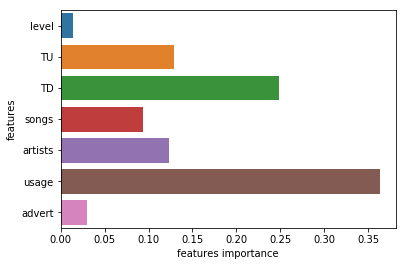

In [58]:
df_featuresimp = pd.DataFrame({'features':df_final.columns[:-1].values.tolist(),'features importance':fit_model2.bestModel.stages[2].featureImportances.values.tolist()})
sns.barplot(y='features',x='features importance',data=df_featuresimp)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

<h3> Summary </h3>
We can see that running random forest we could get better f1 score and it seems the feature with most impact is how usage time and thumbs down. so a good trigger for possible cancellation is the raise of Thumbs down from the user, so we can send disconts ou something similar